In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2025-10-26 17:22:30.955103: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-26 17:22:30.974909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761474150.995019   44835 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761474151.001356   44835 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-26 17:22:31.022165: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
# IMPORTS & KONFIGURASI
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

print("TensorFlow version:", tf.__version__)


BASE_DIR = "dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "validation")
TEST_DIR  = os.path.join(BASE_DIR, "test")

IMG_SIZE = 224   
BATCH_SIZE = 16
EPOCHS = 20
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42


TensorFlow version: 2.18.0


In [4]:
# Mengecek jumlah file per kelas
def count_images_in_dir(dirpath):
    counts = {}
    if not os.path.exists(dirpath):
        print(f"Directory not found: {dirpath}")
        return counts
    for cls in sorted(os.listdir(dirpath)):
        cls_path = os.path.join(dirpath, cls)
        if os.path.isdir(cls_path):
            counts[cls] = sum([1 for _ in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, _))])
    return counts

print("Train counts:", count_images_in_dir(TRAIN_DIR))
print("Validation counts:", count_images_in_dir(VAL_DIR))
print("Test counts:", count_images_in_dir(TEST_DIR))


Train counts: {'gudeg': 90, 'gulai': 80, 'rendang': 82, 'soto': 90}
Validation counts: {'gudeg': 10, 'gulai': 10, 'rendang': 10, 'soto': 10}
Test counts: {'gudeg': 20, 'gulai': 10, 'rendang': 10, 'soto': 10}


In [5]:
# LOAD DATASET
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


Found 342 files belonging to 4 classes.


I0000 00:00:1761474157.319438   44835 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 25297 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:be:00.0, compute capability: 8.9


Found 40 files belonging to 4 classes.
Found 50 files belonging to 4 classes.
Classes: ['gudeg', 'gulai', 'rendang', 'soto']


2025-10-26 17:22:40.999749: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


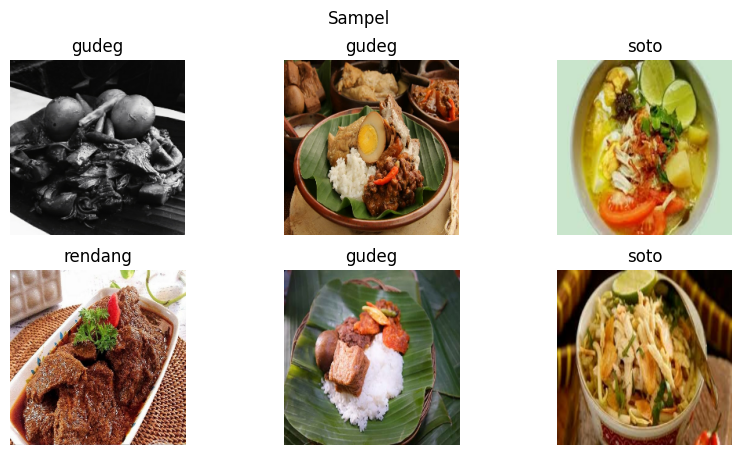

In [6]:
# DATA AUGMENTATION & NORMALIZATION
from tensorflow.keras import layers

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.12),
    layers.RandomZoom(0.08),
], name="data_augmentation")

def prepare_dataset(ds, training=False):
    ds = ds.map(lambda x,y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x,y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
        ds = ds.shuffle(1000, seed=SEED)
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds_prepared = prepare_dataset(train_ds, training=True)
val_ds_prepared = prepare_dataset(val_ds, training=False)
test_ds_prepared = prepare_dataset(test_ds, training=False)

# Show sample images
plt.figure(figsize=(10,5))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(2,3,i+1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sampel")
plt.show()


In [7]:
# definisiin train
def plot_history(hist, title_prefix=""):
    df = pd.DataFrame(hist.history)
    df['epoch'] = range(1, len(df)+1)
    display(df[['epoch'] + [c for c in df.columns if 'accuracy' in c or 'loss' in c]])
    # plot accuracy
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(df['epoch'], df.get('accuracy'), label='train_acc')
    plt.plot(df['epoch'], df.get('val_accuracy'), label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title(title_prefix + " Accuracy")
    # plot loss
    plt.subplot(1,2,2)
    plt.plot(df['epoch'], df.get('loss'), label='train_loss')
    plt.plot(df['epoch'], df.get('val_loss'), label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title(title_prefix + " Loss")
    plt.show()
    return df


Model: "ResNet50_scratch"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 24,060,164 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/20


I0000 00:00:1761474213.590941   45161 service.cc:148] XLA service 0x7f0420002280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761474213.590971   45161 service.cc:156]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-10-26 17:23:34.381166: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761474217.590679   45161 cuda_dnn.cc:529] Loaded cuDNN version 91002


 3/22 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3507 - loss: 1.7556  

I0000 00:00:1761474232.974295   45161 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/22 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3122 - loss: 1.9623

2025-10-26 17:23:59.316924: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16074_0', 8 bytes spill stores, 8 bytes spill loads

2025-10-26 17:24:14.192784: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_36', 416 bytes spill stores, 416 bytes spill loads



21/22 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3150 - loss: 1.9535  

2025-10-26 17:24:21.557630: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1698_0', 8 bytes spill stores, 8 bytes spill loads



22/22 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.3143 - loss: 1.9499 - val_accuracy: 0.2500 - val_loss: 1.3892
Epoch 2/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3198 - loss: 1.6514 

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.3230 - loss: 1.6371 - val_accuracy: 0.2750 - val_loss: 1.3934
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4182 - loss: 1.4922 - val_accuracy: 0.2500 - val_loss: 1.4392
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4587 - loss: 1.2061 - val_accuracy: 0.2500 - val_loss: 1.6254
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5773 - loss: 0.9557 - val_accuracy: 0.2500 - val_loss: 1.9654
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6007 - loss: 0.9440 - val_accuracy: 0.2500 - val_loss: 2.1462
Epoch 7/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6157 - loss: 0.9004  

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.6138 - loss: 0.9028 - val_accuracy: 0.4500 - val_loss: 1.3961
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6608 - loss: 0.7619 - val_accuracy: 0.2750 - val_loss: 1.4512
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6425 - loss: 0.8006 - val_accuracy: 0.3750 - val_loss: 2.0123
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6948 - loss: 0.7095 - val_accuracy: 0.2500 - val_loss: 2.5896
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6097 - loss: 1.0463 - val_accuracy: 0.3750 - val_loss: 2.1869
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6816 - loss: 0.8134 - val_accuracy: 0.4000 - val_loss: 2.3752
Epoch 13/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6727 - loss: 0.7906 - val_accuracy: 0.2750 - val_loss: 3.3538


,epoch,accuracy,loss,val_accuracy,val_loss
0,1,0.307018,1.911539,0.250,1.389237
1,2,0.356725,1.487802,0.275,1.393383
2,3,0.432749,1.412195,0.250,1.439188
3,4,0.491228,1.137691,0.250,1.625364
4,5,0.552632,0.965986,0.250,1.965444
5,6,0.578947,0.992301,0.250,2.146234
6,7,0.593567,0.927367,0.450,1.396112
7,8,0.649123,0.816250,0.275,1.451221
8,9,0.649123,0.805432,0.375,2.012328
9,10,0.675439,0.793351,0.250,2.589563


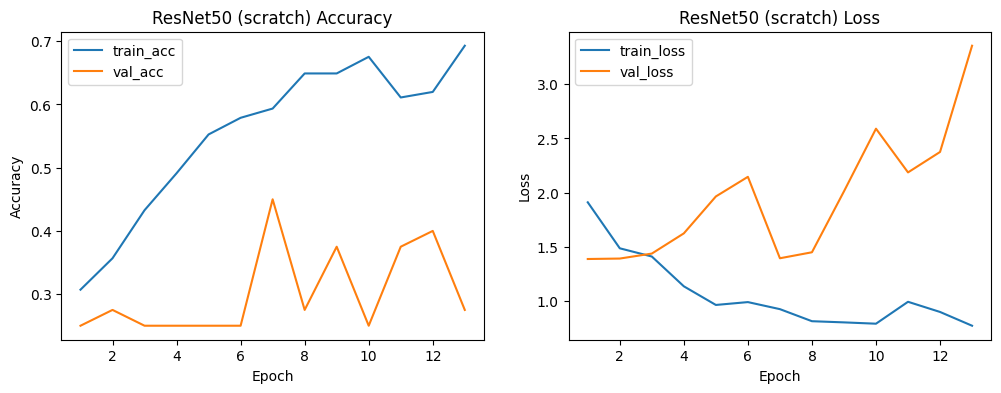

In [8]:
# ResNet50 (tanpa pretrained weights)
from tensorflow.keras.applications import ResNet50

def build_resnet50_custom(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes):
    base = ResNet50(include_top=False, weights=None, input_shape=input_shape, pooling='avg')
    x = base.output
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base.input, outputs=outputs, name="ResNet50_scratch")
    return model

resnet_model = build_resnet50_custom()
resnet_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()

checkpoint_cb_res = callbacks.ModelCheckpoint("resnet50_best.h5", save_best_only=True, monitor='val_accuracy', mode='max')
earlystop_cb_res = callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)

hist_resnet = resnet_model.fit(
    train_ds_prepared,
    validation_data=val_ds_prepared,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb_res, earlystop_cb_res]
)

df_resnet = plot_history(hist_resnet, title_prefix="ResNet50 (scratch)")
df_resnet.to_csv("history_resnet50.csv", index=False)
resnet_model.save("resnet50_final.h5")


In [9]:
# EVALUASI PADA TEST SET
def evaluate_and_confusion_matrix(model_path, ds, class_names):
    if not os.path.exists(model_path):
        print("Model file not found:", model_path)
        return None
    model = tf.keras.models.load_model(model_path)
    loss, acc = model.evaluate(ds)
    print(f"Model {model_path} -> loss: {loss:.4f}, acc: {acc:.4f}")
    y_true = []
    y_pred = []
    for images, labels in ds:
        probs = model.predict(images)
        preds = np.argmax(probs, axis=1)
        y_true.extend(labels.numpy().tolist())
        y_pred.extend(preds.tolist())
    cm = confusion_matrix(y_true, y_pred)
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
    return cm

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 418ms/step - accuracy: 0.1974 - loss: 1.4404  
Model resnet50_best.h5 -> loss: 1.4227, acc: 0.2800
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Report:
               precision    recall  f1-score   support

       gudeg       0.00      0.00      0.00        20
       gulai       0.38      0.50      0.43        10
     rendang       0.00      0.00      0.00        10
        soto       0.24      0.90      0.38        10

    accuracy                           0.28        50
   macro avg       0.16      0.35      0.20        50
weighted avg       0.13      0.28      0.16        50



/opt/tljh/user/envs/dltf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/tljh/user/envs/dltf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/tljh/user/envs/dltf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


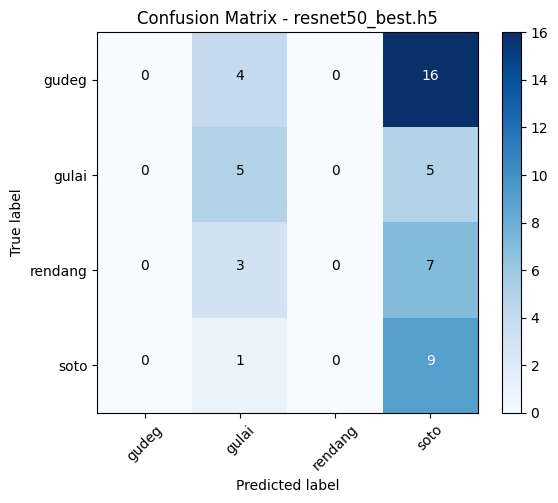

In [11]:
for mfile in ["resnet50_best.h5"]:
    if os.path.exists(mfile):
        cm = evaluate_and_confusion_matrix(mfile, test_ds_prepared, class_names)
        if cm is not None:
            plt.figure(figsize=(6,5))
            plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title(f'Confusion Matrix - {mfile}')
            plt.colorbar()
            tick_marks = np.arange(len(class_names))
            plt.xticks(tick_marks, class_names, rotation=45)
            plt.yticks(tick_marks, class_names)
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, cm[i, j],
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.tight_layout()
            plt.show()
    else:
        print("File not found:", mfile)


In [12]:
MODEL_SAVE_PATH = "resnet50_best.h5"
resnet_model.save(MODEL_SAVE_PATH)
print(f"Model tersimpan di: {MODEL_SAVE_PATH}")


Model tersimpan di: resnet50_best.h5
